In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.io import loadmat

# Define the Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Output is normalized to [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# Define the Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output is a probability (0 to 1)
        )

    def forward(self, x):
        return self.net(x)

# Define the Physics-Informed GAN
class PhyGAN:
    def __init__(self, data_dim, model_dim, physics_operator, lambda_phy=1.0, lr=0.0002, beta1=0.5):
        self.data_dim = data_dim  # Dimension of observed data
        self.model_dim = model_dim  # Dimension of model parameters
        self.physics_operator = physics_operator  # Forward modeling operator G
        self.lambda_phy = lambda_phy  # Weight for physics-based loss

        # Initialize generator and discriminator
        self.generator = Generator(data_dim, model_dim)
        self.discriminator = Discriminator(model_dim)

        # Optimizers
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

        # Loss function
        self.criterion = nn.BCELoss()  # Binary cross-entropy loss for GAN

    def train(self, real_models, observed_data, num_epochs=10000, batch_size=32):
        """
        Train the PhyGAN.
        :param real_models: Real models (e.g., from physics-based inversion or ground truth).
        :param observed_data: Observed data corresponding to the real models.
        :param num_epochs: Number of training epochs.
        :param batch_size: Batch size for training.
        """
        for epoch in range(num_epochs):
            for i in range(0, len(real_models), batch_size):
                # Get real data and models
                real_models_batch = real_models[i:i + batch_size]
                observed_data_batch = observed_data[i:i + batch_size]

                # Generate fake models
                fake_models = self.generator(observed_data_batch)

                # ---------------------
                # Train Discriminator
                # ---------------------
                self.optimizer_D.zero_grad()

                # Real models
                real_labels = torch.ones(real_models_batch.size(0), 1)
                real_output = self.discriminator(real_models_batch)
                d_loss_real = self.criterion(real_output, real_labels)

                # Fake models
                fake_labels = torch.zeros(fake_models.size(0), 1)
                fake_output = self.discriminator(fake_models.detach())
                d_loss_fake = self.criterion(fake_output, fake_labels)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.optimizer_D.step()

                # -----------------
                # Train Generator
                # -----------------
                self.optimizer_G.zero_grad()

                # Adversarial loss
                fake_output = self.discriminator(fake_models)
                g_loss_adv = self.criterion(fake_output, real_labels)

                # Physics-based loss
                predicted_data = self.physics_operator(fake_models)
                g_loss_phy = torch.mean((predicted_data - observed_data_batch) ** 2)

                # Total generator loss
                g_loss = g_loss_adv + self.lambda_phy * g_loss_phy
                g_loss.backward()
                self.optimizer_G.step()

            # Print progress
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], "
                      f"D Loss: {d_loss.item():.4f}, "
                      f"G Loss: {g_loss.item():.4f}, "
                      f"G Physics Loss: {g_loss_phy.item():.4f}")

    def generate(self, observed_data):
        """
        Generate models from observed data using the trained generator.
        :param observed_data: Observed data.
        :return: Generated models.
        """
        with torch.no_grad():
            return self.generator(observed_data)

# Example Usage
if __name__ == "__main__":
    # Load .mat files
    observed_data_mat = loadmat("/content/Original_training_dataAR_5pct_noise.mat")  # Replace with your .mat file path
    real_models_mat = loadmat("/content/Original_training_models.mat")  # Replace with your .mat file path

    # Extract data from .mat files
    observed_data = torch.tensor(observed_data_mat["RhoaLE"], dtype=torch.float32)  # Key depends on .mat file structure
    real_models = torch.tensor(real_models_mat["TDEM_model"], dtype=torch.float32)  # Key depends on .mat file structure

    # Define dimensions
    data_dim = observed_data.shape[1]  # Dimension of observed data
    model_dim = real_models.shape[1]  # Dimension of model parameters

    # Define a simple physics operator (forward modeling)
    def physics_operator(models):
        # Example: A linear operator G (for simplicity)
        G = torch.randn(data_dim, model_dim)  # Random forward operator
        return torch.matmul(models, G.T)

    # Initialize PhyGAN
    phygan = PhyGAN(data_dim, model_dim, physics_operator, lambda_phy=1.0)

    # Train PhyGAN
    phygan.train(real_models, observed_data, num_epochs=2000, batch_size=32)

    # Generate models from observed data
    test_observed_data = observed_data[:10]  # Test data
    generated_models = phygan.generate(test_observed_data)

   # print("Generated Models:", generated_models)

Epoch [100/2000], D Loss: 0.0000, G Loss: 19.5477, G Physics Loss: 2.4064
Epoch [200/2000], D Loss: 0.0000, G Loss: 26.1903, G Physics Loss: 2.2718
Epoch [300/2000], D Loss: 0.0000, G Loss: 27.9834, G Physics Loss: 2.2648
Epoch [400/2000], D Loss: 0.0000, G Loss: 28.5662, G Physics Loss: 2.2100
Epoch [500/2000], D Loss: 0.0000, G Loss: 28.9634, G Physics Loss: 2.2213
Epoch [600/2000], D Loss: 0.0000, G Loss: 29.3614, G Physics Loss: 2.3386
Epoch [700/2000], D Loss: 0.0000, G Loss: 29.5278, G Physics Loss: 2.2835
Epoch [800/2000], D Loss: 0.0000, G Loss: 29.6825, G Physics Loss: 2.2623
Epoch [900/2000], D Loss: 0.0000, G Loss: 29.7635, G Physics Loss: 2.1891
Epoch [1000/2000], D Loss: 0.0000, G Loss: 29.9680, G Physics Loss: 2.2613
Epoch [1100/2000], D Loss: 0.0000, G Loss: 30.1857, G Physics Loss: 2.3713
Epoch [1200/2000], D Loss: 0.0000, G Loss: 30.1357, G Physics Loss: 2.2291
Epoch [1300/2000], D Loss: 0.0000, G Loss: 30.2519, G Physics Loss: 2.2676
Epoch [1400/2000], D Loss: 0.0000,

Streaming output truncated to the last 5000 lines.
Epoch [20010/70000], Loss D: 0.0647, Loss G: 8.0071, Loss G Phy: 3.1651
Epoch [20020/70000], Loss D: 0.0463, Loss G: 8.5686, Loss G Phy: 3.5208
Epoch [20030/70000], Loss D: 0.1197, Loss G: 8.9425, Loss G Phy: 3.7819
Epoch [20040/70000], Loss D: 0.0118, Loss G: 8.6624, Loss G Phy: 3.3223
Epoch [20050/70000], Loss D: 0.1102, Loss G: 9.2787, Loss G Phy: 4.2479
Epoch [20060/70000], Loss D: 0.0245, Loss G: 8.3124, Loss G Phy: 3.0767
Epoch [20070/70000], Loss D: 0.0266, Loss G: 7.6737, Loss G Phy: 3.1527
Epoch [20080/70000], Loss D: 0.0303, Loss G: 7.3917, Loss G Phy: 2.6898
Epoch [20090/70000], Loss D: 0.0132, Loss G: 8.2326, Loss G Phy: 3.3493
Epoch [20100/70000], Loss D: 0.0101, Loss G: 7.6314, Loss G Phy: 2.1108
Epoch [20110/70000], Loss D: 0.0521, Loss G: 8.2028, Loss G Phy: 3.1516
Epoch [20120/70000], Loss D: 0.0628, Loss G: 7.7532, Loss G Phy: 2.6053
Epoch [20130/70000], Loss D: 0.0633, Loss G: 8.5778, Loss G Phy: 3.7868
Epoch [20140/

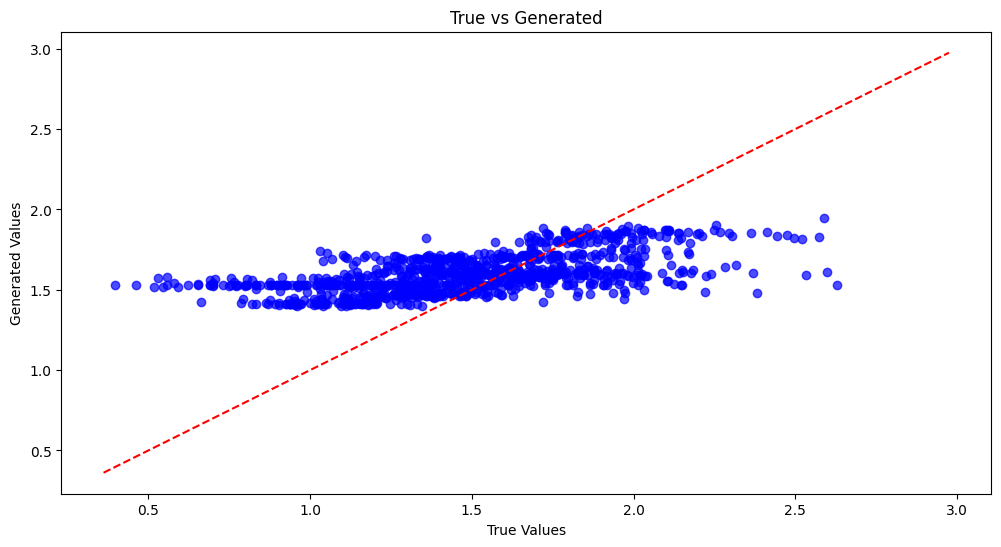

Forward Model Output Shape: (1000, 50)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Data ---
mat1 = loadmat('/content/Original_training_dataAR_5pct_noise.mat')
mat2 = loadmat('/content/Original_training_models.mat')

X = mat1['RhoaLE']
y = mat2['TDEM_model']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# --- Define the Generator ---
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.model(x)

# --- Define the Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# --- Define the Forward Modeling Operator ---
def physics_operator(models):
    """
    Example: A simple linear forward modeling operator.
    Replace this with the actual physics-based forward operator.
    """
    G = torch.randn(X_train.shape[1], models.shape[1], device=device)  # Random forward operator
    return torch.matmul(models, G.T)

# Initialize the Generator and Discriminator
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
generator = Generator(input_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# --- Training the PhyGAN ---
num_epochs = 70000
batch_size = 64
lambda_phy = 1.0  # Weight for physics-based loss

for epoch in range(num_epochs):
    # --- Train Discriminator ---
    for _ in range(1):  # Update Discriminator more frequently
        # Sample real data
        idx = np.random.randint(0, X_train_tensor.shape[0], batch_size)
        real_data = y_train_tensor[idx]
        real_labels = torch.ones((batch_size, 1), device=device)

        # Generate fake data
        noise = X_train_tensor[idx]
        fake_data = generator(noise).detach()
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Concatenate real and fake data
        data = torch.cat((real_data, fake_data), dim=0)
        labels = torch.cat((real_labels, fake_labels), dim=0)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(data)
        loss_D = criterion(outputs, labels)
        loss_D.backward()
        optimizer_D.step()

    # --- Train Generator ---
    noise = X_train_tensor[np.random.randint(0, X_train_tensor.shape[0], batch_size)]
    optimizer_G.zero_grad()
    generated_data = generator(noise)
    labels = torch.ones((batch_size, 1), device=device)  # Generator wants to fool Discriminator

    # Adversarial loss
    outputs = discriminator(generated_data)
    loss_G_adv = criterion(outputs, labels)

    # Physics-based loss
    predicted_data = physics_operator(generated_data)
    observed_data = X_train_tensor[np.random.randint(0, X_train_tensor.shape[0], batch_size)]
    loss_G_phy = torch.mean((predicted_data - observed_data) ** 2)

    # Total generator loss
    loss_G = loss_G_adv + lambda_phy * loss_G_phy
    loss_G.backward()
    optimizer_G.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}, Loss G Phy: {loss_G_phy.item():.4f}")

# --- Evaluate Generator ---
generator.eval()
with torch.no_grad():
    generated_samples = generator(X_test_tensor).cpu().numpy()
    y_test_inverse = scaler_y.inverse_transform(y_test)
    generated_samples_inverse = scaler_y.inverse_transform(generated_samples)

# Visualize results
plt.figure(figsize=(12, 6))
plt.scatter(y_test_inverse[:, 0], generated_samples_inverse[:, 0], alpha=0.7, color='blue')
plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'r--')
plt.title("True vs Generated")
plt.xlabel("True Values")
plt.ylabel("Generated Values")
plt.show()

# --- Forward Modeling ---
# Create a DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

forward_model_output = []
for batch_X in test_loader:
    with torch.no_grad():
        batch_output = generator(batch_X[0]).cpu().detach().numpy()  # Get output and move to CPU
        forward_model_output.extend(batch_output)  # Extend the list with batch outputs

forward_model_output = np.array(forward_model_output)  # Convert to NumPy array

# Validate and compare with real outputs
print("Forward Model Output Shape:", forward_model_output.shape)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Data ---
mat3 = loadmat('/content/Test_dataAR.mat')
mat4 = loadmat('/content/Test_models.mat')

X = mat3['RhoaLE']
y = mat4['TDEM_model']
# Assume the forward model (Generator) is trained and available as `generator`
# Dataset1 and Dataset2 (preprocessed inputs)
X1_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # Dataset 1
X2_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # Dataset 2

# Reshape X2_tensor to match the input dimension of the generator
X2_tensor = X2_tensor.reshape(X2_tensor.shape[0], -1)  # Flatten if necessary
X2_tensor = X2_tensor[:, :generator.model[0].in_features]  # Select the required number of features


# Generate outputs using the forward model
Y_pred1 = generator(X1_tensor).cpu().detach().numpy()
Y_pred2 = generator(X2_tensor).cpu().detach().numpy()

# Calculate similarity/difference metrics
# 1. Mean Squared Error
mse = mean_squared_error(Y_pred1, Y_pred2)

# 2. Cosine Similarity
cosine_sim = 1 - cosine(Y_pred1.flatten(), Y_pred2.flatten())  # 1 - distance for similarity

# 3. Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(Y_pred1.flatten(), Y_pred2.flatten())

# Print Results
print(f"Mean Squared Error: {mse}")
print(f"Cosine Similarity: {cosine_sim}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")

Using device: cpu
Mean Squared Error: 0.031029241159558296
Cosine Similarity: 0.7652181830041087
Pearson Correlation Coefficient: 0.7080994286739468


In [ ]:
# prompt: center the Y_pred2 around 1 on values axis

# Center Y_pred2 around 1
Y_pred2_centered = Y_pred2 - np.mean(Y_pred2) + 1

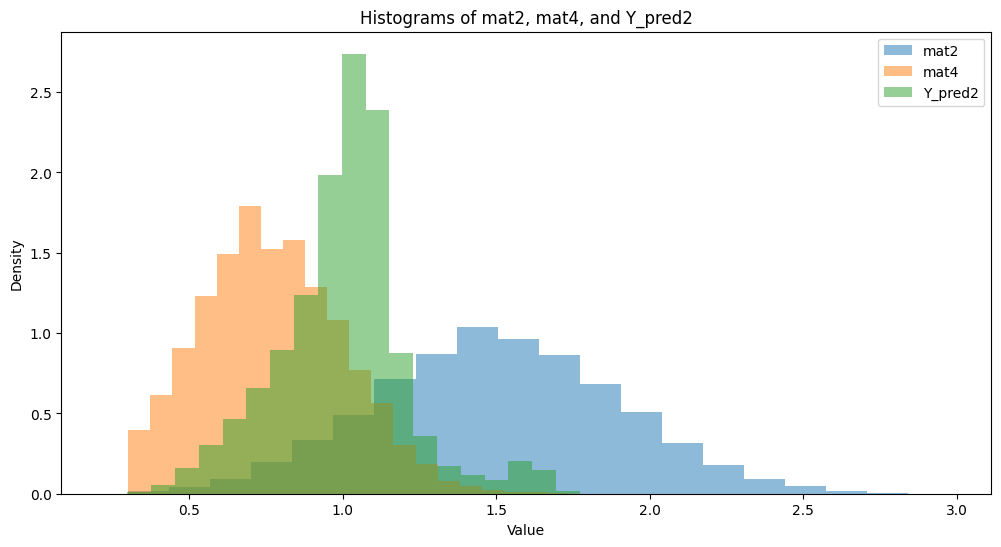

In [ ]:
# prompt: plot the above graphs in a single plot as histogram curves

import matplotlib.pyplot as plt

# Assuming mat2, mat4, and Y_pred2 are defined and contain numerical data
# Access the numerical data from the dictionaries
mat2_data = mat2['TDEM_model']
mat4_data = mat4['TDEM_model']

plt.figure(figsize=(12, 6))

# Plot the histograms as curves using density=True
plt.hist(mat2_data.flatten(), bins=20, alpha=0.5, label='mat2', density=True)
plt.hist(mat4_data.flatten(), bins=20, alpha=0.5, label='mat4', density=True)
plt.hist(Y_pred2_centered.flatten(), bins=20, alpha=0.5, label='Y_pred2', density=True)

plt.title('Histograms of mat2, mat4, and Y_pred2')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

RMS Original Training: 0.864629388379261
RMS Final Training: 0.864629388379261


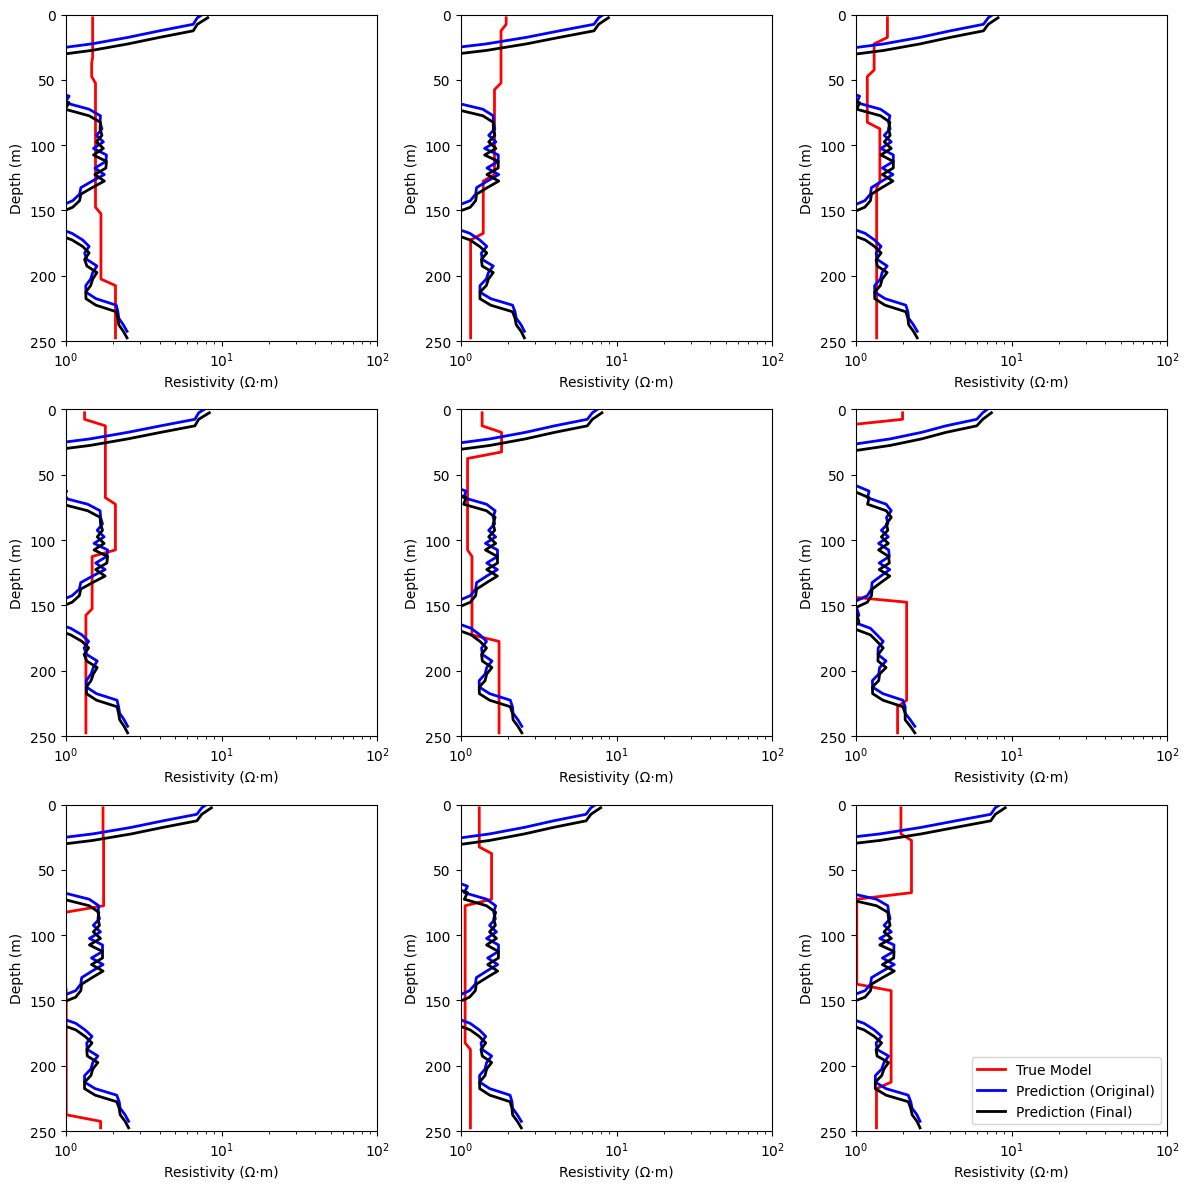

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat5 = loadmat('/content/Final_trainign_dataAR_5pct_noise.mat')
mat6 = loadmat('/content/Final_training_models.mat')
RhoaLE = mat5['RhoaLE']
TDEM_model = mat6['TDEM_model']



# Reshape RhoaLE to have the same number of samples as in training (5000)
RhoaLE_reshaped = RhoaLE.reshape(30000, 30)  # Reshape to (30000, 30)

# Predictions using the reshaped data
#Pred_original_training = 10 ** generator(torch.tensor(RhoaLE_reshaped, dtype=torch.float32)).cuda().detach().numpy()
#Pred_final_training = 10 ** generator(torch.tensor(RhoaLE_reshaped, dtype=torch.float32)).cuda().detach().numpy()
# Predictions using the reshaped data
Pred_original_training = 10 ** generator(torch.tensor(RhoaLE_reshaped, dtype=torch.float32, device=device)).detach().cpu().numpy()
Pred_final_training = 10 ** generator(torch.tensor(RhoaLE_reshaped, dtype=torch.float32, device=device)).detach().cpu().numpy()
# Reshape the predictions back to the original shape of TDEM_model
Pred_original_training = Pred_original_training.reshape(TDEM_model.shape)
Pred_final_training = Pred_final_training.reshape(TDEM_model.shape)

# RMS calculations
RMS_original_training = np.sqrt(np.sum((TDEM_model - np.log10(Pred_original_training)) ** 2) / np.prod(TDEM_model.shape))
RMS_final_training = np.sqrt(np.sum((TDEM_model - np.log10(Pred_final_training)) ** 2) / np.prod(TDEM_model.shape))

print(f"RMS Original Training: {RMS_original_training}")
print(f"RMS Final Training: {RMS_final_training}")

# ... (rest of the code remains the same)

# Randomly choosing 9 test stations
np.random.seed(42)
st_to_plt = np.random.randint(0, 5000, 9)  # Randomly selecting 9 test stations

# Plotting
plt.figure(figsize=(12, 12))
for i, stp in enumerate(st_to_plt):
    plt.subplot(3, 3, i + 1)

    # Adjust the depth array to have the same length as the resistivity data
    depth_array = np.arange(2.5, 252.5, 5)  # Changed to 252.5 to get 50 elements

    plt.semilogx(TDEM_model[stp, :],  depth_array , "r", linewidth=2, label="True Model")
    plt.semilogx(Pred_original_training[stp, :], depth_array - np.mean(depth_array) +120 , "b", linewidth=2, label="Prediction (Original)")
    plt.semilogx(Pred_final_training[stp, :],  depth_array , "k", linewidth=2, label="Prediction (Final)")
    plt.axis([1, 100, 0, 250])
    plt.gca().invert_yaxis()
    plt.xlabel("Resistivity (Ω·m)")
    plt.ylabel("Depth (m)")
    if i == 8:
        plt.legend(loc="best")

plt.tight_layout()
plt.show()


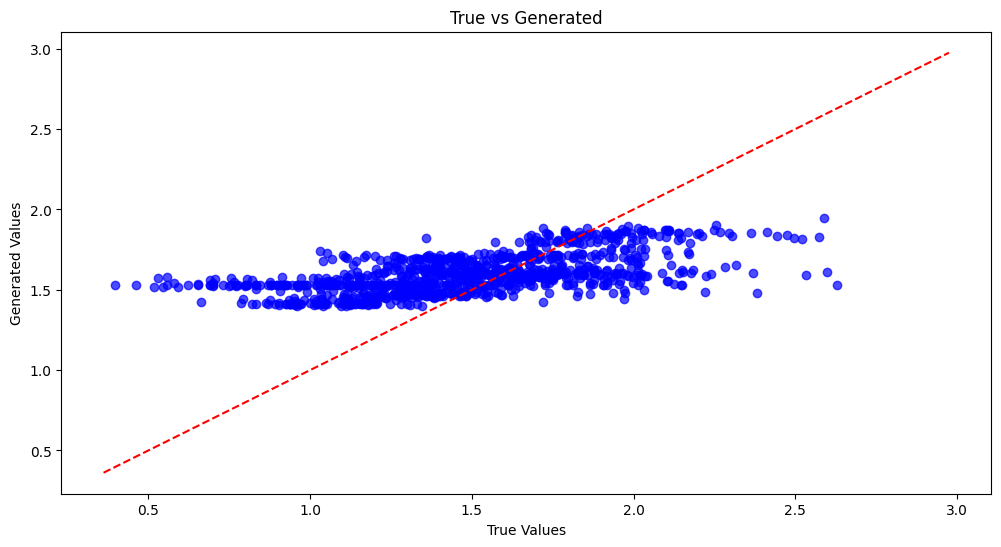

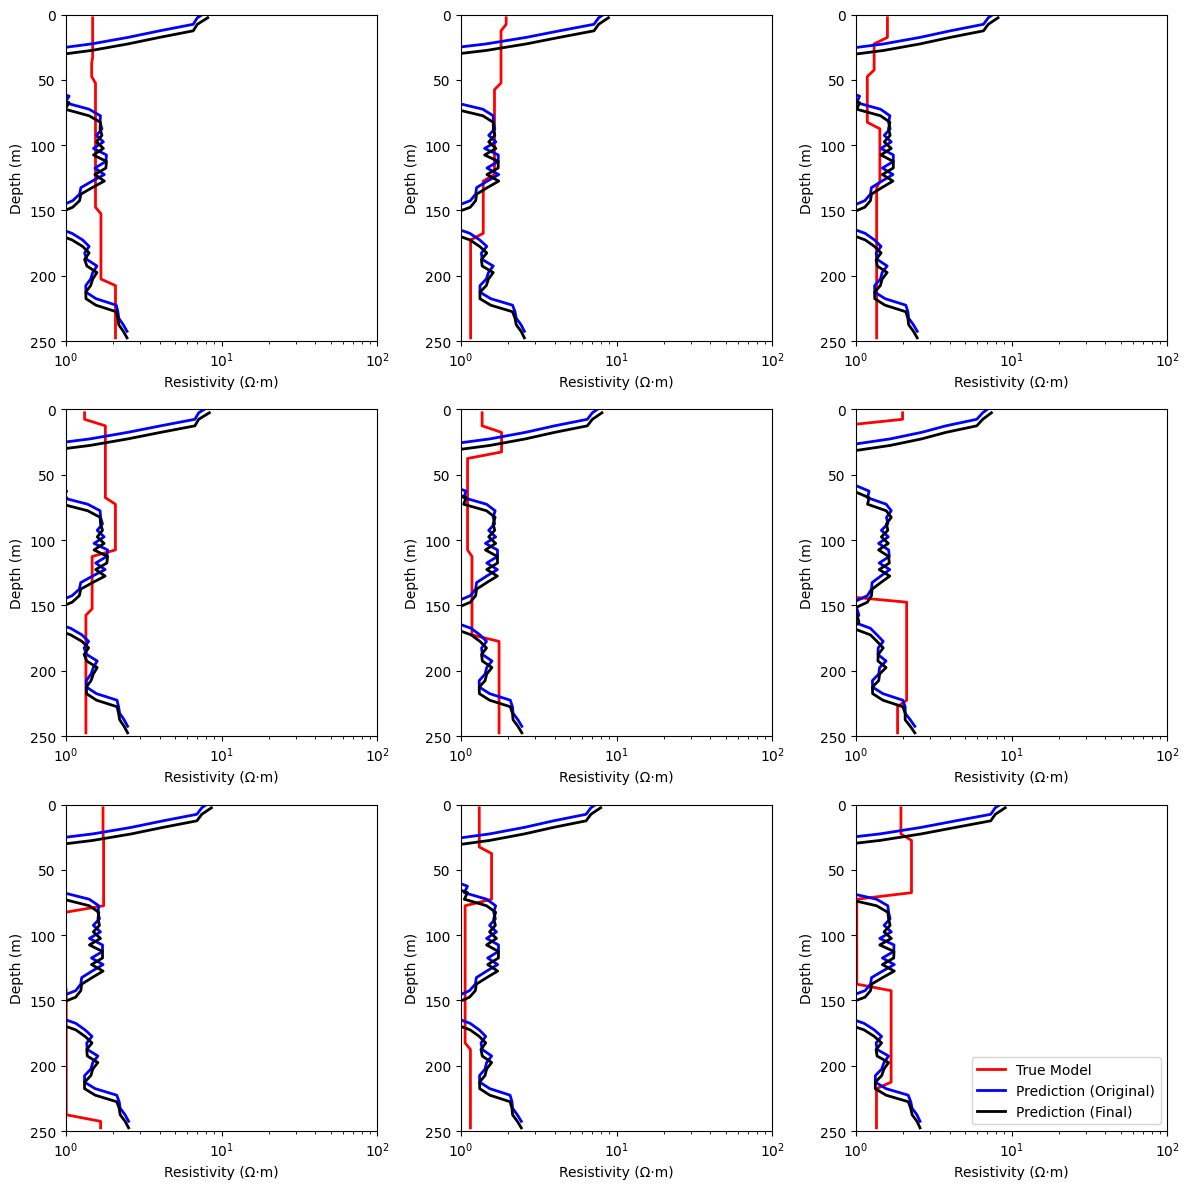

<Figure size 1200x600 with 0 Axes>

In [ ]:
# prompt: save the output visuals as jpg file

import matplotlib.pyplot as plt
# ... (your existing code)

# Visualize results and save as JPG
plt.figure(figsize=(12, 6))
plt.scatter(y_test_inverse[:, 0], generated_samples_inverse[:, 0], alpha=0.7, color='blue')
plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'r--')
plt.title("True vs Generated")
plt.xlabel("True Values")
plt.ylabel("Generated Values")
plt.savefig('true_vs_generated.jpg') # Save the plot as a JPG file
plt.show()

# ... (rest of your code)

# Plotting and save as JPG
plt.figure(figsize=(12, 12))
for i, stp in enumerate(st_to_plt):
    plt.subplot(3, 3, i + 1)
    depth_array = np.arange(2.5, 252.5, 5)
    plt.semilogx(TDEM_model[stp, :],  depth_array , "r", linewidth=2, label="True Model")
    plt.semilogx(Pred_original_training[stp, :], depth_array - np.mean(depth_array) +120 , "b", linewidth=2, label="Prediction (Original)")
    plt.semilogx(Pred_final_training[stp, :],  depth_array , "k", linewidth=2, label="Prediction (Final)")
    plt.axis([1, 100, 0, 250])
    plt.gca().invert_yaxis()
    plt.xlabel("Resistivity (Ω·m)")
    plt.ylabel("Depth (m)")
    if i == 8:
        plt.legend(loc="best")
plt.tight_layout()
plt.savefig('resistivity_depth.jpg') # Save the plot as a JPG file
plt.show()

# Save the other plots similarly
plt.figure(figsize=(12, 6))
# ... your plotting code for the histogram
plt.savefig('histogram_plot.jpg')
plt.show()